# Structural Estimation of a Full Blow Consumption Model

1. This notebooks estimates the consumption model in **ConsumptionSaving.pdf** using **egm** to solve the model for guesses over parameter values
2. Show how to calculate standard errors and sensitivity measures

This notebook assumes that you have a fair understanding of the model and how to solve it. We will focus on how to estimate parameters of the model, denoted $\theta$.

## Simulated Minimum Distance
We assume here that we have data available for $n$ units over $T$ periods, collected in $\{w_i\}_i^n$ and that our model is correctly specified in the sense that the observed data stems from the model, we wish to estimate with the true, unknown, parameters $\theta_0$. We thus wish to use the observed data to infer the unknown parameters of the model by estimating $\theta$ by combining optimal behavior in the model and the observed data.

Concretely, we will focus on matching certain (well-chosen) moments in the data to simulated moments from the model. A simulated General Method of Moments (GMM) type estimator. Imagine that we calculate a $J\times1$ vector of moments in the data, $\Lambda_{data} = \frac{1}{n}\sum_{i=1}^n m(\theta_0|w_i)$. This could e.g. be average consumption over the life cycle, the income variance or regressions coefficients from some statistical model. The latter is sometimes referred to as "auxiliary parameters" (APs) and the estimator using these APs as an Indirect Inference (II) estimator ([Gouriéroux, Monfort and Renault, 1993](https://onlinelibrary.wiley.com/doi/abs/10.1002/jae.3950080507 "Link to paper")). We will not descriminate here and simply allow for all types of moments and APs to enter in the vector of moments.

To estimate $\theta$ we will chose $\theta$ as to minimize the (squared) distance between the moments in the data and the same moments calculated from simulated data. Let $\Lambda_{sim}(\theta) = \frac{1}{n_{sim}}\sum_{s=1}^{n_{sim}} m(\theta|w_s)$ be the same moments calculated on simulated data for $n_{sim}=S\times n$ observations for $T_{sim}$ periods from the model for a given value of $\theta$. As we change $\theta$, the simulated outomes will change and the moments will too. Be aware, though, that if you have discrete choices in the model, there is a risk that simulated behavior does not change when changing $\theta$ slightly.

The Simulated Minimum Distance (SMD) estimator is then
\begin{equation}
\hat{\theta} = \arg\min_{\theta} g(\theta)'Wg(\theta)
\end{equation}
where $W$ is a $J\times J$ positive semi definite weighting matrix and
\begin{equation}
g(\theta)=\Lambda_{data}-\Lambda_{sim}(\theta)
\end{equation}
is the distance between $J\times1$ vectors of *moments* calculated in the data and the simulated data, respectively. Concretely,
$\Lambda_{data} = \frac{1}{n}\sum_{i=1}^n m(\theta_0|w_i)$ and $\Lambda_{sim}(\theta) = \frac{1}{n_{sim}}\sum_{s=1}^{n_{sim}} m(\theta|w_s)$ are $J\times1$ vectors of moments calculated in the data and the simulated data, respectively. 

In our baseline setup, we will have $n=5,000$ observations for $T=35$ periods and simulate $n_{sim}=100,000$ synthetic consumers for 40 periods when estimating the model. 

This estimator requires the solution (and simulation) of the model for all trial guesses of $\theta$ as we search for the one that minimizes the objective function. Therefore, structural estimation can in general be quite time-consuming. We will use the EGM to solve the consumption model quite fast and thus be able to estimate parameters within a couple of minutes. Estimation of more complex models might take significantly longer.

# Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import scipy.optimize as optimize

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

import figs
from ConsumptionSavingModel import ConsumptionSavingModelClass
from SimulatedMinimumDistance import SimulatedMinimumDistanceClass

# Setup estimation details

In [2]:
# a. parameters to estimate
est_par = {
    'rho': {'guess':2.0,'lower':0.5,'upper':5.0,},
    'beta': {'guess':0.97,'lower':0.90,'upper':0.999},
}
est_par_names = [key for key,_ in est_par.items()]

# b. number of consumers
n = 5_000       # number of consumers in actual data
n_sim = 100_000 # number of synthetic consumers to simulate when estimating theta

# c. moment function used in estimation. 
# the moments chosen should be informative (and this identify) the parameters in theta
def mom_func(data,ids=None):
    '''Returns the age profile of wealth '''
    
    if ids is None:
        return np.mean(data.A[:,1:],axis=0)
    else:
        return np.mean(data.A[ids,1:],axis=0)

# d. choose weighting matrix
    # 0: identity (equal weight),
    # 1: inverse of variance on the diagonal (removes scale), 
    # 2: inverse of covaraince matrix between estimation moments (optimal weighting matrix)
weighting_matrix = 0   

# Setup Consumption model and simulate "true" data 

model solved in 1.9 secs
model simulated in 1.4 secs


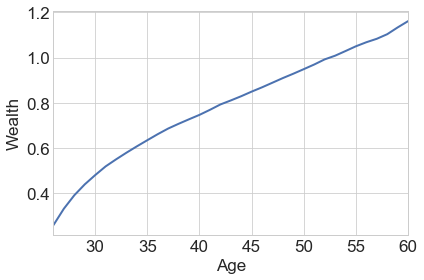

In [3]:
# simulation setup
par = {'sim_mini':1.0 ,'simlifecycle':1, 'simT':36,'simN':n_sim}
model = ConsumptionSavingModelClass(name='estimated',solmethod='egm',**par)

# synthetic data and moments
par['simN'] = n # number of observations, n
model_true = ConsumptionSavingModelClass(name='true',solmethod='egm',**par)
model_true.solve()
model_true.simulate(seed=2019) # this is different from the default

datamoms = mom_func(model_true.sim)
moment_names = [i for i in range(model.par.age_min+1,model.par.age_min+model.par.simT)]

# setup the SMD estimator for the current model and parameters of interest
smd = SimulatedMinimumDistanceClass(est_par,mom_func,datamoms=datamoms)

# plot moments in data
smd.plot({'Wealth':moment_names},{'Wealth':datamoms},xlabel='Age',ylabel='Wealth',hide_legend=True)

# Estimate the Model

## Estimation functions

In [4]:
# bootstrap variance of estimation moments. Used for standard errors below and potentially for weighting matrix
num_boot = 200
num_moms = datamoms.size
smd.Omega = smd.bootstrap_mom_var(model_true.sim,n,num_boot,num_moms)

# Choose weighting matrix
if weighting_matrix == 0:
    W = np.eye(smd.datamoms.size) # identity
elif weighting_matrix == 1:
    W = np.diag(1.0/np.diag(smd.Omega)) # inverse of variance on the diagonal
else:
    W = np.linalg.inv(smd.Omega) # optimal weighting matrix

## Estimation results

In [5]:
# estimate the model (can take several minutes)
%time est = smd.estimate(model,W)

# print estimation results
print(f'       True  Est. ')
for key,val in est_par.items():
    print(f'{key:5s} {getattr(model_true.par,key):2.3f} {est[key]:2.3f}')

Objective function at starting values: 4.3633418469119585
Wall time: 1min 55s
       True  Est. 
rho   2.000 1.989
beta  0.960 0.960


## Standard errors
The SMD estimator is asymptotic Normal and standard errors have the same form as standard GMM estimators scaled with the adjustment factor $(1+S^{-1})$ due to the fact that we use $S$ simulations of the model.

The standard errors are thus 
\begin{align}
Var(\hat{\theta})&=(1+S^{-1})\Gamma\Omega\Gamma'/n \\
\Gamma &= -(G'WG)^{-1}G'W \\
\Omega & = Var(m(\theta_0|w_i))
\end{align}
and $G=\frac{\partial g(\theta)}{\partial \theta}$ is the $J\times K$ Jacobian matrix with respect to $\theta$.

We can sometimes calculate $Var(m(\theta_0|w_i))$ analytically but another approach is to bootstrap this object using the data. We did this already above because one (optimal) choice of weighting matrix is $W=\Omega^{-1}$.

We now thus need to calculate $G$. We will use numerical finite differences to do this.

In [6]:
S = model.par.simN/n # number of datasets simulated per individual in original data
Gamma,grad_theta = smd.calc_gamma(est['theta'],model,W)
Var_theta = (1.0+1.0/S) * Gamma @ smd.Omega @ Gamma.T /n
se = np.sqrt(np.diag(Var_theta))

# print estimation results
print(f'       True  Est.  (se)')
for i,(key,val) in enumerate(est_par.items()):
    print(f'{key:5s} {getattr(model_true.par,key):2.3f} {est[key]:2.3f} ({se[i]:2.3f})')

       True  Est.  (se)
rho   2.000 1.989 (0.038)
beta  0.960 0.960 (0.001)


# Sensitivity Analysis
We will now look into a sensitivity analysis of our estimation. Concretely, we will implement the informativeness measure from [Honoré, Jørgensen and de Paula (2019)](https://arxiv.org/abs/1907.02101v2 "The Informativeness of Estimation Moments") and the sensitivity to calibrated parameters in [Jørgensen (2020)](www.tjeconomics.com "Sensitivity to Calibrated Parameters").

## The Informativeness of Estimation Moments
The measures are motivated by those proposed in [Honoré, Jørgensen and de Paula (2019)](https://arxiv.org/abs/1907.02101v2 "The Informativeness of Estimation Moments"). All the measures proposed in that paper is calculated, but we will focus on their measure 4 that asks "what is the change in the asymptotic variance from completely excluding the k'th moment?". If the *k*th is very informative about a parameter, the asymptotic varaince of that parameter should increase significantly, if we leave out the *k*th moment.

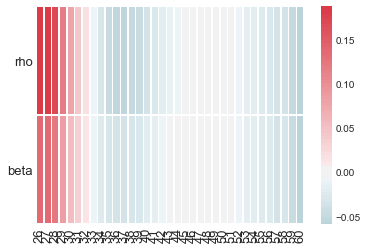

In [7]:
info = smd.informativeness_moments(grad_theta,smd.Omega,W)

smd.plot_heat(info['M4e'],est_par_names,moment_names,annot=False)

We can see that especially the wealth level for younger households are very informative regarding both $\rho$ and $\beta$. This is likely due to the fact that for low level of resources (which is the case at younger ages), the value of both these parameters affect consumption and saving decisions alot. Thus, the level of saving especially in young ages are very informative and help to identify the two parameters.

## Sensitivity to Calibrated parameters
The mesure is motivated by the one proposed in [Jørgensen (2020)](www.tjeconomics.com "Sensitivity to Calibrated Parameters"). Note that the estimation moments are all functions of the $L$ calibrated parameters which we will denote $\gamma$, $g(\theta|\gamma)$. 

The measure is defined as
\begin{align}
S &= \Gamma D
\end{align}
where $D=\frac{\partial g(\theta|\gamma)}{\partial \gamma}$ is the $J\times L$ Jacobian matrix with respect to $\gamma$. 

*We only need to calculate $D$* since we have already calculated $\Gamma$ when we calculated standard errors above. We will again use numerical finite differences to calcualte this object.

In [8]:
# setup which parameters are in gamma and whether to compare to brute-force approach
cali_par_names = ('R','G')
cali_par = np.array([getattr(model.par,name) for name in cali_par_names])
do_brute_force = True

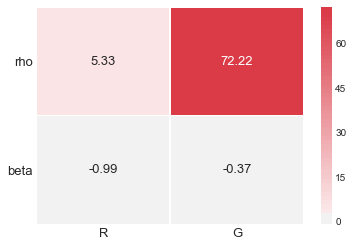

In [9]:
# calculate the sensitivity measure 
grad_gamma = smd.num_grad(cali_par,model,cali_par_names)
sens_cali = Gamma @ grad_gamma

# plot sensitivity measure
smd.plot_heat(sens_cali,est_par_names,cali_par_names)

In [10]:
# calculate elasticities
sens_cali_e = np.empty(sens_cali.shape)
for j in range(cali_par.size):
    for i in range(est['theta'].size):
        sens_cali_e[i,j] = sens_cali[i,j] * cali_par[j]/est['theta'][i]

#smd.plot_heat(sens_cali_e,est_par_names,cali_par_names)

We can compare this to a brute-force approach in which we re-estimate the model for marginal changes in the calibrated parameters. This takes considerable time, however.
The results are almost identical

now re-estimating with R = 1.040010 (original 1.040000)
Objective function at starting values: 4.377984771199142
now re-estimating with G = 1.020010 (original 1.020000)
Objective function at starting values: 4.340187449963912


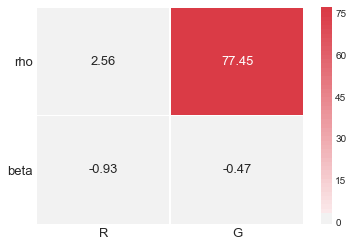

In [11]:
if do_brute_force:
    sens_cali_brute = smd.sens_cali_brute_force(model,est['theta'],W,cali_par_names)
    
    # plot brute-force measure
    smd.plot_heat(sens_cali_brute,est_par_names,cali_par_names)

### Arbitrary changes in $\gamma$
Another approach suggested is to investigate larger simultaneous changes in $\gamma$.

In [12]:
# set new calibrated parameters
cali_par_new = {'G':1.05}

# update calibrated parameters in new version of the model
model_new = model.copy()
for key,val in cali_par_new.items():
    setattr(model_new.par,key,val)

# calculate new objective function
obj_vec = smd.diff_vec_func(est['theta'],model,est_par_names)
obj_vec_new = smd.diff_vec_func(est['theta'],model_new,est_par_names)

# approximate change in theta
Gamma_new,_ = smd.calc_gamma(est['theta'],model_new,W)
theta_delta =  Gamma_new @ obj_vec_new - Gamma @ obj_vec
print(theta_delta)

# extrapolate the gradient
theta_delta_extrap = np.zeros(theta_delta.size)
for j,key in enumerate(cali_par_new):
    theta_delta_extrap += sens_cali[:,j]*(cali_par_new[key]-getattr(model.par,key))

print(theta_delta_extrap)

[ 3.28545335 -0.25633671]
[ 0.15986272 -0.02963125]


Again, we can compare this approximation to a brute-force re-estimation of the model for the changed $\gamma$.

In [13]:
if do_brute_force:
    est_new = smd.estimate(model_new,W)
    theta_delta_brute = est_new['theta'] - est['theta']
    print(theta_delta_brute)

Objective function at starting values: 1.6611824373754174
[ 0.35691761 -0.06022267]
